In [17]:
import mlflow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, make_pipeline
from category_encoders import BinaryEncoder
from sklearn.compose import ColumnTransformer

In [9]:
class BasicExplorer:
    @staticmethod
    def basic_info(data: pd.DataFrame):
        print(data.head())
        print(data.describe())
        print(data.info())

    def histograms(data: pd.DataFrame):
        data.hist(bins=15, figsize=(15,10))
        plt.show()

    def correlation_matrix(data: pd.DataFrame):
        aux_data = pd.DataFrame()
        aux_data['Gender'] = data['Gender'] == 'Male'
        aux_data['class'] = data['class'] == 'Positive'
        for column in data.columns[2:-1]:
            aux_data[column] = data[column] == 'Yes'
        plt.figure(figsize=(12,8))
        sns.heatmap(aux_data.corr(numeric_only=True), annot=True, fmt=".2f", cmap="coolwarm")

In [18]:
class DiabetesRisk:
    def __init__(self, filepath):
        self.filepath = filepath
        #self.pipeline = self.create_pipeline()
        self.X_train, self.X_test, self.y_train, self.y_test = [None] * 4

    def create_pipeline(self):
        numeric_pipeline = Pipeline(
            steps=[
                ("scaler", StandardScaler()),
            ]
        )
        categorical_pipeline = Pipeline(
            steps=[
                ("binary", BinaryEncoder())
            ]
        )
        preprocessor = ColumnTransformer(
            [
                ("categorical", categorical_pipeline, self.data.columns[1:-1].to_list()),
                ("numerical", numeric_pipeline, self.data.columns[:1].to_list())
            ]
        )
        self.pipeline = make_pipeline(preprocessor, LogisticRegression(max_iter=1000))
        return self
    
    def load_data(self):
        self.data = pd.read_csv(self.filepath)
        BasicExplorer.basic_info(self.data)
        return self
    
    def preprocess_data(self):
        X = self.data.drop('class', axis=1)
        y = self.data['class']
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.2, random_state=35)
        return self
    
    def train_model(self):
        self.pipeline.fit(self.X_train, self.y_train)
        return self
    
    def evaluate_model(self):
        print('-----Evalución del modelo-----')
        y_pred = self.pipeline.predict(self.X_test)
        cm = confusion_matrix(self.y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(self.y_test))
        disp.plot(cmap="Blues")
        plt.show()

        report = classification_report(self.y_test, y_pred)
        print(report)
        return self

    def cv_model(self):
        scores = cross_val_score(self.pipeline, self.X_train, self.y_train, cv = 5)
        print("Average Accuracy with CV:", np.mean(scores))
        return self




   Age Gender Polyuria Polydipsia sudden weight loss weakness Polyphagia  \
0   40   Male       No        Yes                 No      Yes         No   
1   58   Male       No         No                 No      Yes         No   
2   41   Male      Yes         No                 No      Yes        Yes   
3   45   Male       No         No                Yes      Yes        Yes   
4   60   Male      Yes        Yes                Yes      Yes        Yes   

  Genital thrush visual blurring Itching Irritability delayed healing  \
0             No              No     Yes           No             Yes   
1             No             Yes      No           No              No   
2             No              No     Yes           No             Yes   
3            Yes              No     Yes           No             Yes   
4             No             Yes     Yes          Yes             Yes   

  partial paresis muscle stiffness Alopecia Obesity     class  
0              No              Yes      

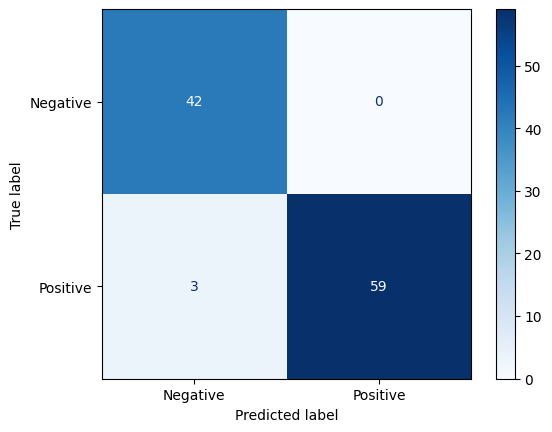

              precision    recall  f1-score   support

    Negative       0.93      1.00      0.97        42
    Positive       1.00      0.95      0.98        62

    accuracy                           0.97       104
   macro avg       0.97      0.98      0.97       104
weighted avg       0.97      0.97      0.97       104

Average Accuracy with CV: 0.9134825014343086


In [19]:
path = r"..\data\raw\diabetes_data_upload.csv"
model = DiabetesRisk(path)
model.load_data()
model.create_pipeline()
model.preprocess_data()
model.train_model()
model.evaluate_model()
model.cv_model()